In [37]:
import numpy as np
import cv2
import rosbag
import rospy
import math
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.spatial.transform import Rotation as R
from datetime import datetime, timedelta
from scipy.spatial import cKDTree
import itertools
import copy
import glob
from copy import deepcopy
from pyproj import Proj, transform
from mpl_toolkits.basemap import Basemap

In [38]:
bag_path="2024-08-01-12-22-33.bag"

In [39]:
ttyUSB0 = {}
ttyTHS2 = {}
init_time = None

with rosbag.Bag(bag_path, 'r') as bag:
    for topic, msg, t in bag.read_messages():
        if init_time == None:
            try:
                init_time = datetime.fromtimestamp(msg.header.stamp.secs) + timedelta(microseconds=msg.header.stamp.nsecs/ 1e9)
                print(init_time)
            except Exception as e:
                print("no init")
        if "ttyUSB0" in topic:
            if not topic in ttyUSB0:
                ttyUSB0[topic] = []
            else:
                ttyUSB0[topic].append(msg)
        if "ttyTHS2" in topic:
            if not topic in ttyTHS2:
                ttyTHS2[topic] = []
            else:
                ttyTHS2[topic].append(msg)


2024-08-01 14:22:33


In [ ]:
for key in ttyUSB0.keys():
    ttyUSB0[key] = np.array(ttyUSB0[key])

for key in ttyTHS2.keys():
    ttyTHS2[key] = np.array(ttyTHS2[key])

In [ ]:
ttyUSB0["latlong"] = []
ttyTHS2["latlong"] = []
ttyUSB0["EastingNorthing"] = []
ttyTHS2["EastingNorthing"] = []
ttyUSB0["CovLog10"] = []
ttyTHS2["CovLog10"] = []
ttyUSB0["status"] = []
ttyTHS2["status"] = []
ttyUSB0["service"] = []
ttyTHS2["service"] = []
ttyUSB0["time"] = []
ttyTHS2["time"] = []

wgs84 = Proj(init='epsg:4326')
utm = Proj(proj="utm", zone=34, datum="WGS84")

for item in ttyUSB0["/dev/ttyUSB0/gps/fix"]:
    time = datetime.fromtimestamp(item.header.stamp.secs) + timedelta(microseconds=item.header.stamp.nsecs / 1e9)
    ttyUSB0["latlong"].append((item.latitude, item.longitude))
    easting, northing = transform(wgs84, utm, item.latitude, item.longitude)
    ttyUSB0["EastingNorthing"].append((easting, northing))
    ttyUSB0["CovLog10"].append(np.log10(item.position_covariance))
    ttyUSB0["status"].append(item.status.status)
    ttyUSB0["service"].append(item.status.service)
    ttyUSB0["time"].append((time-init_time).total_seconds())

for item in ttyTHS2["/dev/ttyTHS2/gps/fix"]:
    time = datetime.fromtimestamp(item.header.stamp.secs) + timedelta(microseconds=item.header.stamp.nsecs / 1e9)
    easting, northing = transform(wgs84, utm, item.latitude, item.longitude)
    ttyTHS2["EastingNorthing"].append((easting, northing))  
    ttyTHS2["latlong"].append((item.latitude, item.longitude))
    ttyTHS2["CovLog10"].append(np.log10(item.position_covariance))
    ttyTHS2["status"].append(item.status.status)
    ttyTHS2["service"].append(item.status.service)
    ttyTHS2["time"].append((time-init_time).total_seconds())

ttyUSB0["latlong"] = np.array(ttyUSB0["latlong"])
ttyTHS2["latlong"] = np.array(ttyTHS2["latlong"])
ttyUSB0["EastingNorthing"] = np.array(ttyUSB0["EastingNorthing"])
ttyTHS2["EastingNorthing"] = np.array(ttyTHS2["EastingNorthing"])
ttyUSB0["CovLog10"] = np.array(ttyUSB0["CovLog10"])
ttyTHS2["CovLog10"] = np.array(ttyTHS2["CovLog10"])
ttyUSB0["status"] = np.array(ttyUSB0["status"])
ttyTHS2["status"] = np.array(ttyTHS2["status"])
ttyUSB0["service"] = np.array(ttyUSB0["service"])
ttyTHS2["service"] = np.array(ttyTHS2["service"])
ttyUSB0["time"] = np.array(ttyUSB0["time"])
ttyTHS2["time"] = np.array(ttyTHS2["time"])

/home/annika/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_22230/61862490.py:20: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  easting, northing = transform(wgs84, utm, item.latitude, item.longitude)
/tmp/ipykernel_22230/61862490.py:22: RuntimeWarning: invalid value encountered in log10
  ttyUSB0["CovLog10"].append(np.log10(item.position_covariance))
/tmp/ipykernel_22230/61862490.py:29: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  easting, northing = trans

In [ ]:
print(ttyTHS2["time"][0]) 
print(ttyUSB0["time"][0])

2.000001
1.000001


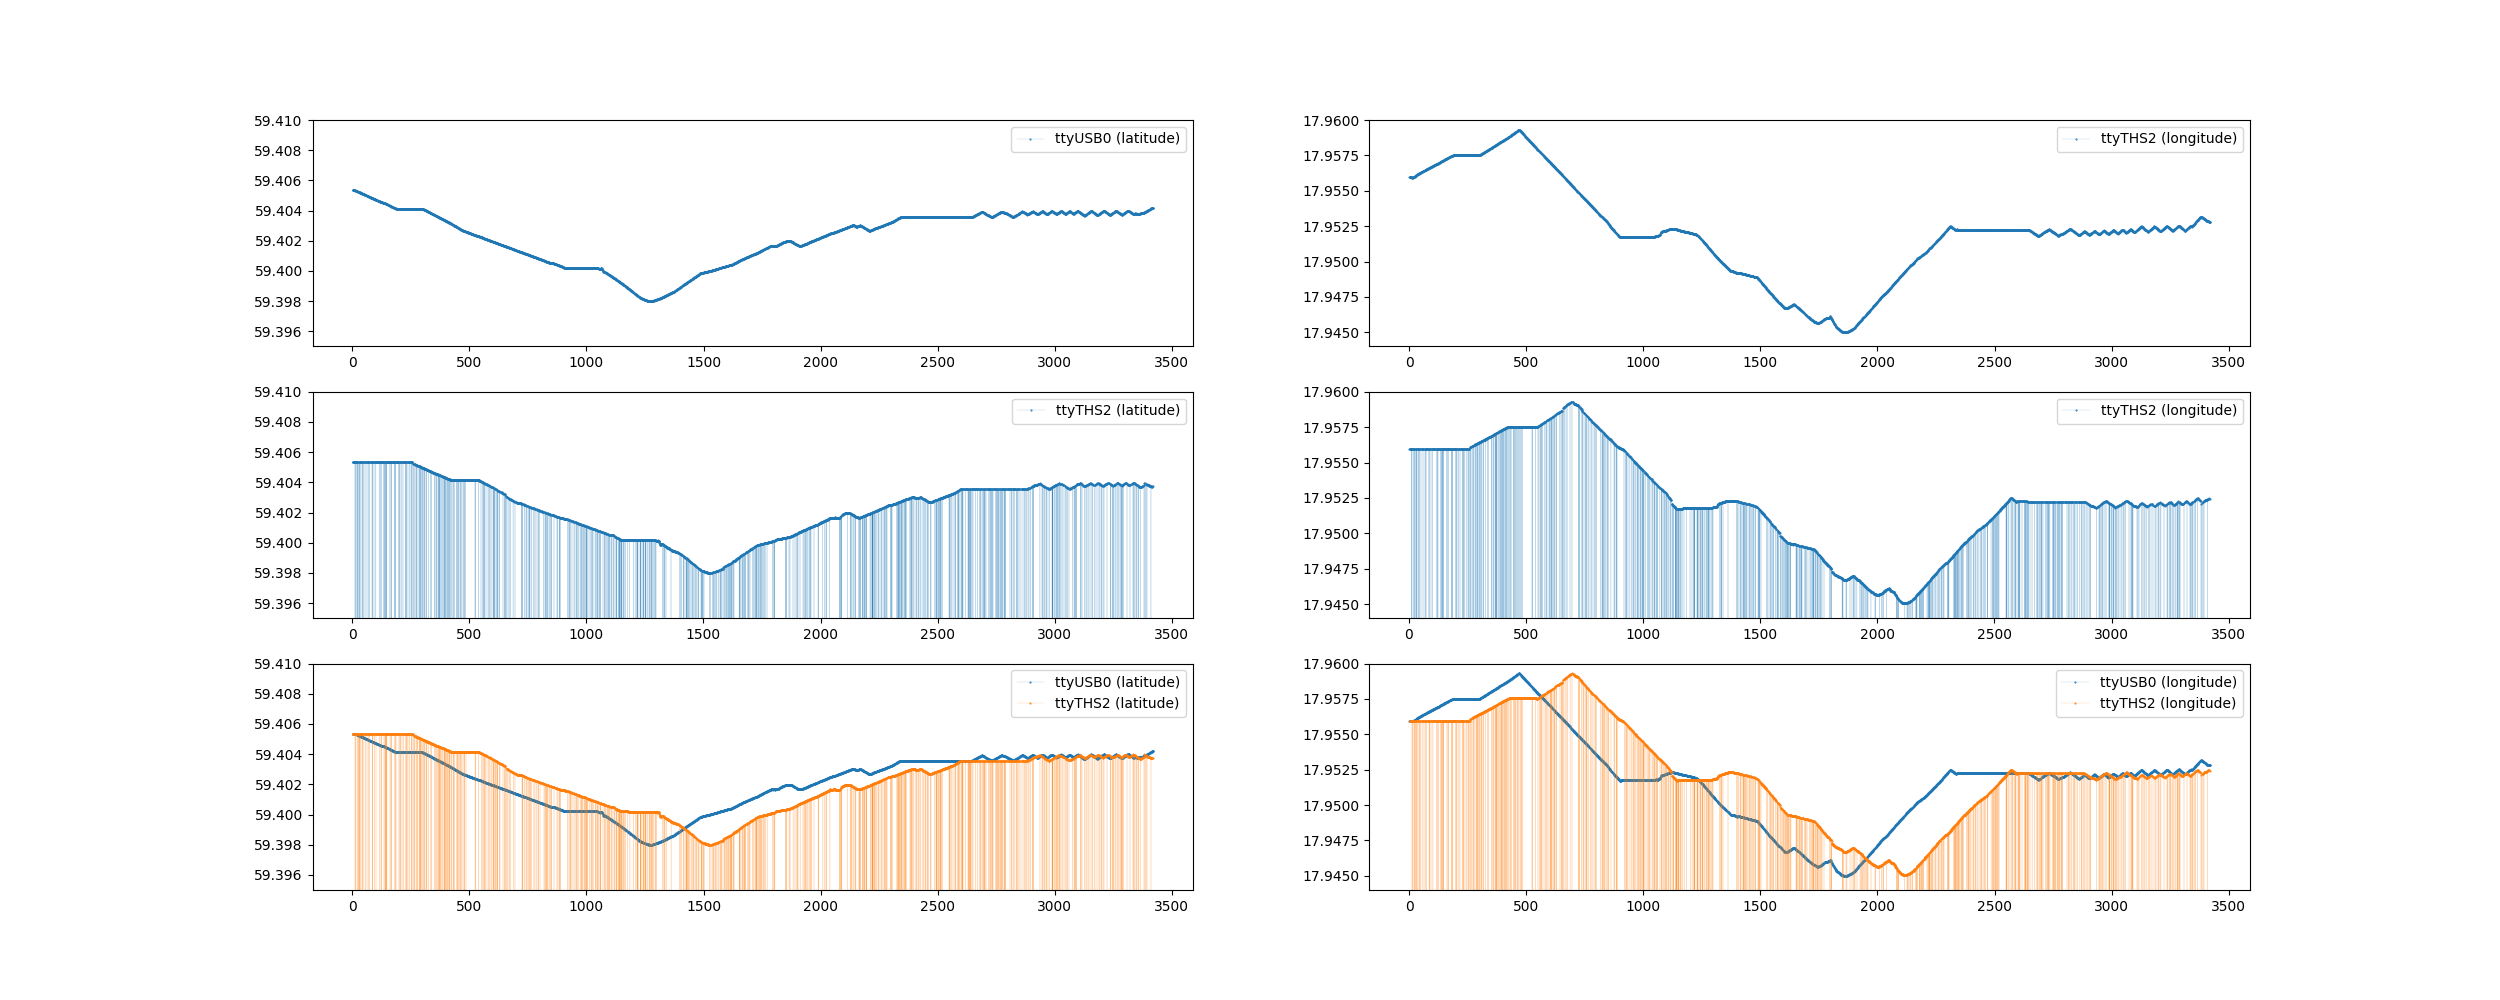

In [ ]:
%matplotlib widget
figure, ax = plt.subplots(3,2, figsize=(25,10))
ax[0,0].plot(ttyUSB0["time"], ttyUSB0["latlong"][:,0], linewidth=0.1, marker="o", markersize=0.5, label="ttyUSB0 (latitude)")
ax[0,0].set_ylim(59.395, 59.41)
ax[0,0].legend()

ax[0,1].plot(ttyUSB0["time"], ttyUSB0["latlong"][:,1], linewidth=0.1, marker="o", markersize=0.5, label="ttyTHS2 (longitude)")
ax[0,1].set_ylim(17.944, 17.960)
ax[0,1].legend()

ax[1,0].plot(ttyTHS2["time"], ttyTHS2["latlong"][:,0], linewidth=0.1, marker="o", markersize=0.5, label="ttyTHS2 (latitude)")
ax[1,0].set_ylim(59.395, 59.41)
ax[1,0].legend()
ax[1,1].plot(ttyTHS2["time"], ttyTHS2["latlong"][:,1], linewidth=0.1, marker="o", markersize=0.5, label="ttyTHS2 (longitude)")
ax[1,1].set_ylim(17.944, 17.960)
ax[1,1].legend()

ax[2,0].plot(ttyUSB0["time"], ttyUSB0["latlong"][:,0], linewidth=0.1, marker="o", markersize=0.5, label="ttyUSB0 (latitude)")
ax[2,0].plot(ttyTHS2["time"], ttyTHS2["latlong"][:,0], linewidth=0.1, marker="o", markersize=0.5, label="ttyTHS2 (latitude)")
ax[2,0].set_ylim(59.395, 59.41)
ax[2,0].legend()
ax[2,1].plot(ttyUSB0["time"],ttyUSB0["latlong"][:,1], linewidth=0.1, marker="o", markersize=0.5, label="ttyUSB0 (longitude)")
ax[2,1].plot(ttyTHS2["time"],ttyTHS2["latlong"][:,1], linewidth=0.1, marker="o", markersize=0.5, label="ttyTHS2 (longitude)")
ax[2,1].set_ylim(17.944, 17.960)
ax[2,1].legend()


2489000.0


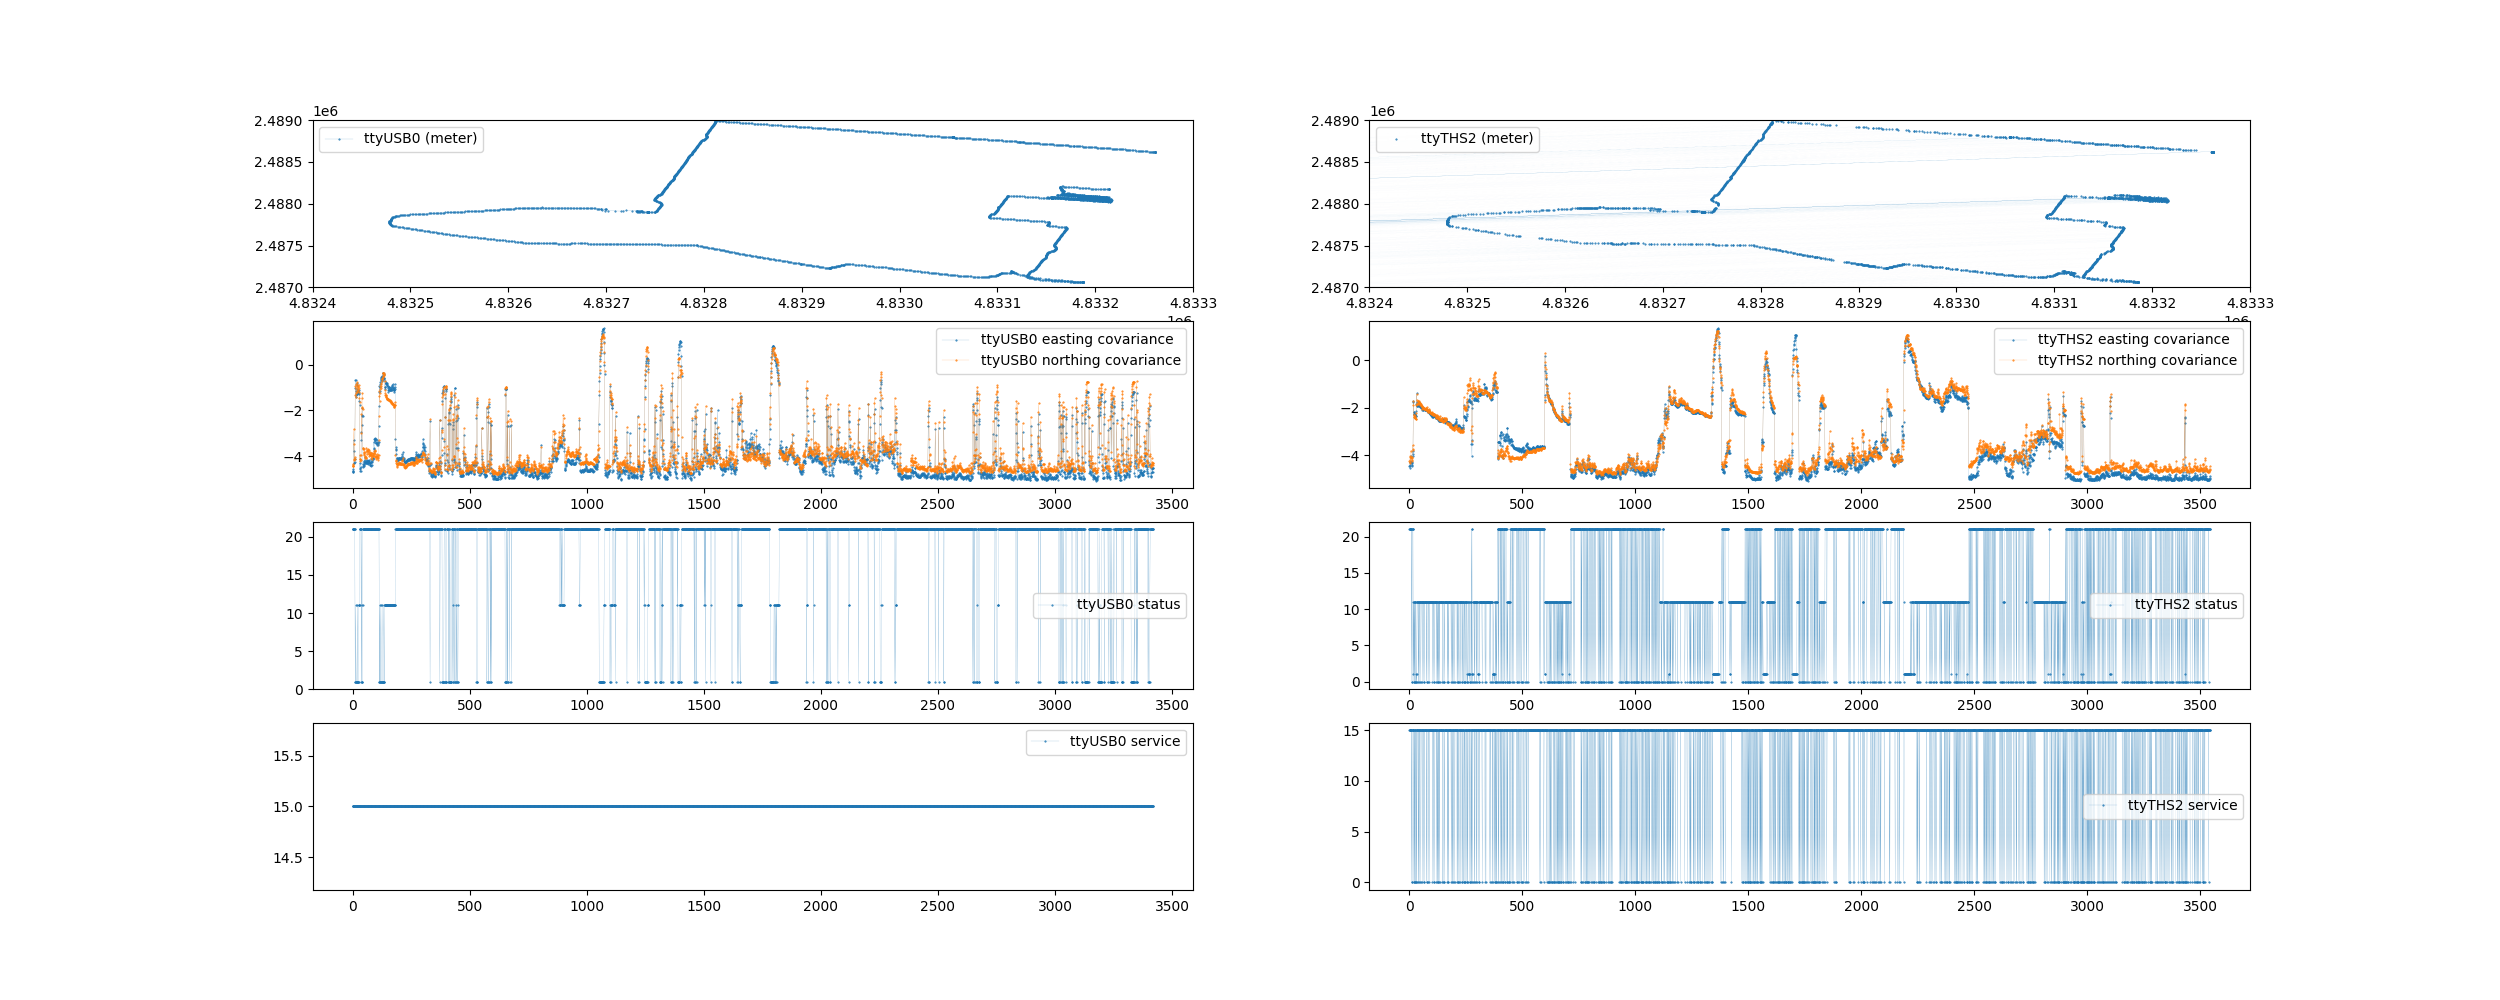

In [ ]:
%matplotlib widget
figure, ax = plt.subplots(4,2, figsize=(25,10))
# ax[0,0].plot(ttyUSB0["latlong"][:,0], ttyUSB0["latlong"][:,1], label="ttyUSB0")
ax[0,0].plot(ttyUSB0["EastingNorthing"][:,0], ttyUSB0["EastingNorthing"][:,1], linewidth=0.1, marker="o", markersize=0.5, label="ttyUSB0 (meter)")
ax[0,0].set_xlim(4832400, 4833300)
ax[0,0].set_ylim(2487000, 2489000)
ax[0,0].legend()

# ax[0,1].plot(ttyTHS2["latlong"][:,0], ttyTHS2["latlong"][:,1], label="ttyTHS2")
ax[0,1].plot(ttyTHS2["EastingNorthing"][:,0], ttyTHS2["EastingNorthing"][:,1], linewidth=0.001, marker="o", markersize=0.5, label="ttyTHS2 (meter)")
ax[0,1].set_xlim(4832400, 4833300)
ax[0,1].set_ylim(2487000, 2489000)
ax[0,1].legend()

ax[1,0].plot(ttyUSB0["CovLog10"][:,0], linewidth=0.1, marker="o", markersize=0.5, label="ttyUSB0 easting covariance")
ax[1,0].plot(ttyUSB0["CovLog10"][:,4], linewidth=0.1, marker="o", markersize=0.5, label="ttyUSB0 northing covariance")
ax[1,0].legend()

ax[1,1].plot(ttyTHS2["CovLog10"][:,0], linewidth=0.1, marker="o", markersize=0.5, label="ttyTHS2 easting covariance")
ax[1,1].plot(ttyTHS2["CovLog10"][:,4], linewidth=0.1, marker="o", markersize=0.5, label="ttyTHS2 northing covariance")
ax[1,1].legend()

ax[2,0].plot(ttyUSB0["status"], linewidth=0.1, marker="o", markersize=0.5, label="ttyUSB0 status")
ax[2,0].legend()
ax[2,1].plot(ttyTHS2["status"], linewidth=0.1, marker="o", markersize=0.5, label="ttyTHS2 status")
ax[2,1].legend()

ax[3,0].plot(ttyUSB0["service"], linewidth=0.1, marker="o", markersize=0.5, label="ttyUSB0 service")
ax[3,0].legend()
ax[3,1].plot(ttyTHS2["service"], linewidth=0.1, marker="o", markersize=0.5, label="ttyTHS2 service")
ax[3,1].legend()

ttyUSB0
Number of points larger than 20: 2895 of total 3420, percentage of 84.64912280701753
Number of points 10-19: 174 of total 3420, percentage of 5.087719298245614
Number of points less than 10: 351 of total 3420, percentage of 10.263157894736842
ttyTHS2
Number of points larger than 20: 1665 of total 3543, percentage of 46.994072819644366
Number of points 10-19: 1037 of total 3543, percentage of 29.268981089472202
Number of points less than 10: 841 of total 3543, percentage of 23.736946090883432


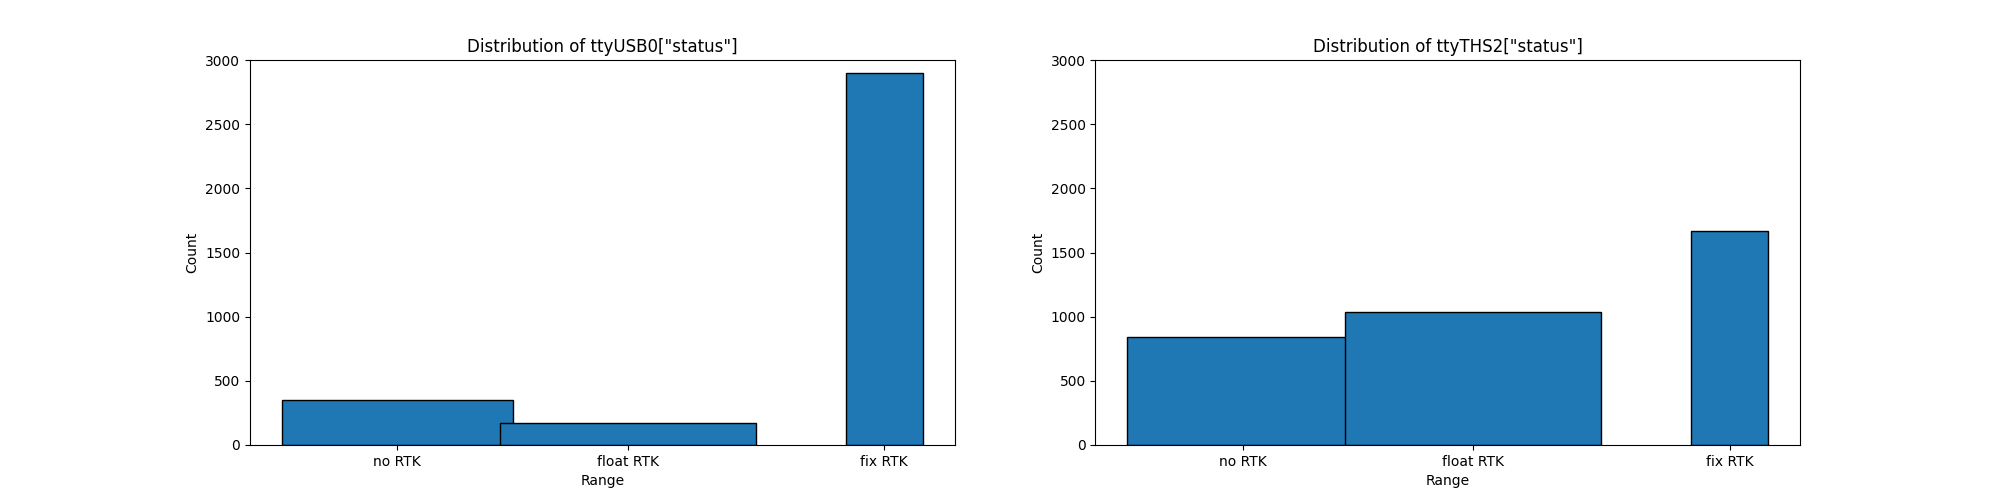

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
bin_labels = ['no RTK', 'float RTK', 'fix RTK']
ax[0].hist(ttyUSB0["status"], bins=[0, 9, 19, max(ttyUSB0["status"]) + 1], edgecolor='black', align='left')
ax[0].set_xlabel('Range')
ax[0].set_ylabel('Count')
ax[0].set_title('Distribution of ttyUSB0["status"]')
ax[0].set_xticks(ticks=[0, 9, 19], labels=bin_labels)
ax[0].set_ylim(0,3000)

ax[1].hist(ttyTHS2["status"], bins=[0, 9, 19, max(ttyTHS2["status"]) + 1], edgecolor='black', align='left')
ax[1].set_xlabel('Range')
ax[1].set_ylabel('Count')
ax[1].set_title('Distribution of ttyTHS2["status"]')
ax[1].set_xticks(ticks=[0, 9, 19], labels=bin_labels)
ax[1].set_ylim(0,3000)

count = len([point for point in ttyUSB0["status"] if point >= 20])
count2 = len([point for point in ttyUSB0["status"] if 10 <= point < 20])
count3 = len([point for point in ttyUSB0["status"] if point < 10])

USBlength = len(ttyUSB0["status"])
print(f"ttyUSB0")
print(f"Number of points larger than 20: {count} of total {USBlength}, percentage of {(count/USBlength)*100}")
print(f"Number of points 10-19: {count2} of total {USBlength}, percentage of {(count2/USBlength)*100}")
print(f"Number of points less than 10: {count3} of total {USBlength}, percentage of {(count3/USBlength)*100}")
print("===========================================")
count = len([point for point in ttyTHS2["status"] if point >= 20])
count2 = len([point for point in ttyTHS2["status"] if 10 <= point < 20])
count3 = len([point for point in ttyTHS2["status"] if point < 10])

THSlength = len(ttyTHS2["status"])
print(f"ttyTHS2")
print(f"Number of points larger than 20: {count} of total {THSlength}, percentage of {(count/THSlength)*100}")
print(f"Number of points 10-19: {count2} of total {THSlength}, percentage of {(count2/THSlength)*100}")
print(f"Number of points less than 10: {count3} of total {THSlength}, percentage of {(count3/THSlength)*100}")
print("===========================================")

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import folium

/home/annika/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_22230/759134838.py:2: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly 

In [ ]:
latlong_data = ttyUSB0["latlong"]
geometry = [Point(lon, lat) for lat, lon in latlong_data]
geo_df = gpd.GeoDataFrame(geometry=geometry, columns=['geometry'])
geo_df.crs = "EPSG:4326"

mean_lat = np.mean([lat for lat, lon in latlong_data])
mean_lon = np.mean([lon for lat, lon in latlong_data])
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=35)

radius = 0.5
for lat, lon in latlong_data:
    folium.CircleMarker(location=[lat, lon], color="cornflowerblue", fill=True, radius=radius).add_to(m)

latlong_data = ttyTHS2["latlong"]
geometry = [Point(lon, lat) for lat, lon in latlong_data]
geo_df = gpd.GeoDataFrame(geometry=geometry, columns=['geometry'])
geo_df.crs = "EPSG:4326"
for lat, lon in latlong_data:
    folium.CircleMarker(location=[lat, lon], color="orange", fill=True, radius=radius).add_to(m)

legend_html = '''
     <div style="position: fixed; 
     bottom: 50px; left: 50px; width: 150px; height: 90px; 
     background-color: white; border:2px solid grey; z-index:9999; font-size:14px;">
     &nbsp; <b>Legend</b> <br>
     &nbsp; ttyUSB0 &nbsp; <i class="fa fa-circle fa-2x" style="color:cornflowerblue"></i><br>
     &nbsp; ttyTHS2 &nbsp; <i class="fa fa-circle fa-2x" style="color:orange"></i>
     </div>
     '''

m.get_root().html.add_child(folium.Element(legend_html))
m.save('test_gps_kista_no_filter.html')
m

In [ ]:
# %matplotlib widget
# figure, ax = plt.subplots(1,2, figsize=(25,6))
# ax[0].plot(ttyUSB0["EastingNorthing"][:,0], ttyUSB0["EastingNorthing"][:,1], label="ttyUSB0")
# ax[0].plot(ttyTHS2["EastingNorthing"][:,0], ttyTHS2["EastingNorthing"][:,1], label="ttyTHS2")
# ax[0].legend()
# ax[1].plot(ttyUSB0["latlong"][:,0], ttyUSB0["latlong"][:,1], label="ttyUSB0")
# ax[1].plot(ttyTHS2["latlong"][:,0], ttyTHS2["latlong"][:,1], label="ttyTHS2")
# ax[1].legend()
# geometry = [Point(lon, lat) for lat, lon in ttyUSB0["latlong"]]
# geo_df = gpd.GeoDataFrame(geometry=geometry)
# geo_df.crs = "EPSG:4326"
# geo_df.plot(ax=ax[1], marker='o', color='red', markersize=5)
# ctx.add_basemap(ax[1], crs=geo_df.crs.to_string())
